In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3080
1


In [4]:
!pip install pycox

  Using cached pycox-0.2.3-py3-none-any.whl (73 kB)
  Using cached torchtuples-0.2.2-py3-none-any.whl (41 kB)
  Using cached feather-format-0.4.1.tar.gz (3.2 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 66.7/66.7 kB 3.5 MB/s eta 0:00:00
     --------------------------------------- 21.5/21.5 MB 10.2 MB/s eta 0:00:00
  Using cached pybcj-1.0.1-cp37-cp37m-win_amd64.whl (24 kB)
  Using cached pyppmd-1.0.0-cp37-cp37m-win_amd64.whl (46 kB)
  Using cached texttable-1.6.7-py2.py3-none-any.whl (10 kB)
  Using cached Brotli-1.0.9-cp37-cp37m-win_amd64.whl (365 kB)
     ---------------------------------------- 1.7/1.7 MB 11.1 MB/s eta 0:00:00
     -------------------------------------- 245.3/245.3 kB 7.6 MB/s eta 0:00:00
  Using cached inflate64-0.3.1-cp37-cp37m-win_amd64.whl (35 kB)
  Using cached multivolumefile-0.2.3-py3-none-any.whl (17 kB)
  Created wheel for feather-format: filename=fea

In [35]:
!pip install scikit-survival

  Using cached scikit_survival-0.17.2-cp37-cp37m-win_amd64.whl (706 kB)
     -------------------------------------- 292.9/292.9 kB 9.1 MB/s eta 0:00:00
  Using cached ecos-2.0.12-cp37-cp37m-win_amd64.whl (71 kB)
     ---------------------------------------- 85.6/85.6 kB ? eta 0:00:00


In [29]:
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier

In [18]:
# Plot the time-depdendent ROC and calculate AUC
from sksurv.metrics import cumulative_dynamic_auc

In [19]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
#import datetime
#import scipy.stats

%matplotlib inline
#plt.rc('font', family='NanumBarunGothic')
plt.rcParams['font.family'] = 'Noto Sans KR'
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
train_dummies = pd.read_csv('C:/Users/user/desktop/kopis/train_C_dummy.csv')
val_dummies= pd.read_csv('C:/Users/user/desktop/kopis/val_C_dummy.csv')
test_dummies= pd.read_csv('C:/Users/user/desktop/kopis/test_C_dummy.csv')

In [5]:
X_train = train_dummies.drop(['delta', 'y'], axis=1)
#y_train = train_dummies['delta']

X_val = val_dummies.drop(['delta', 'y'], axis=1)
#y_val = val_dummies['delta']

X_test = test_dummies.drop(['delta', 'y'], axis=1)
#y_test = test_dummies['delta']

In [6]:
X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
X_test = X_test.values.astype('float32')

In [7]:
get_target = lambda df: (df['y'].values, df['delta'].values)
y_train = get_target(train_dummies)
y_val = get_target(val_dummies)
durations_test, events_test = get_target(test_dummies)
val = X_val, y_val

In [80]:
in_features = X_train.shape[1]
num_nodes = [1024, 1024]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [81]:
model = CoxPH(net, tt.optim.Adam)

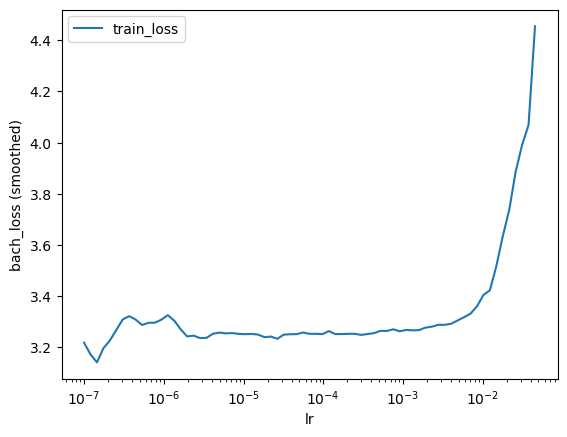

In [93]:
batch_size = 128
lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [94]:
lrfinder.get_best_lr()

0.0001

In [95]:
model.optimizer.set_lr(0.0001)

In [103]:
epochs = 256
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
verbose = True

In [104]:
%%time
log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

13:	[21s / 21s],		train_loss: 3.2624,	val_loss: 3.6134
14:	[21s / 43s],		train_loss: 3.2622,	val_loss: 3.6099
15:	[21s / 1m:5s],		train_loss: 3.2612,	val_loss: 3.6070
16:	[22s / 1m:27s],		train_loss: 3.2612,	val_loss: 3.6112
17:	[22s / 1m:49s],		train_loss: 3.2595,	val_loss: 3.6106
18:	[22s / 2m:11s],		train_loss: 3.2590,	val_loss: 3.6082
19:	[22s / 2m:34s],		train_loss: 3.2556,	val_loss: 3.6103
20:	[22s / 2m:56s],		train_loss: 3.2555,	val_loss: 3.6072
21:	[22s / 3m:18s],		train_loss: 3.2553,	val_loss: 3.6113
22:	[22s / 3m:41s],		train_loss: 3.2548,	val_loss: 3.6133
23:	[22s / 4m:4s],		train_loss: 3.2527,	val_loss: 3.6065
24:	[22s / 4m:26s],		train_loss: 3.2495,	val_loss: 3.6090
25:	[22s / 4m:49s],		train_loss: 3.2520,	val_loss: 3.6072
26:	[22s / 5m:11s],		train_loss: 3.2502,	val_loss: 3.6077
27:	[22s / 5m:34s],		train_loss: 3.2482,	val_loss: 3.6100
28:	[22s / 5m:56s],		train_loss: 3.2476,	val_loss: 3.6057
29:	[22s / 6m:19s],		train_loss: 3.2461,	val_loss: 3.6101
30:	[22s / 6m:42s],		t

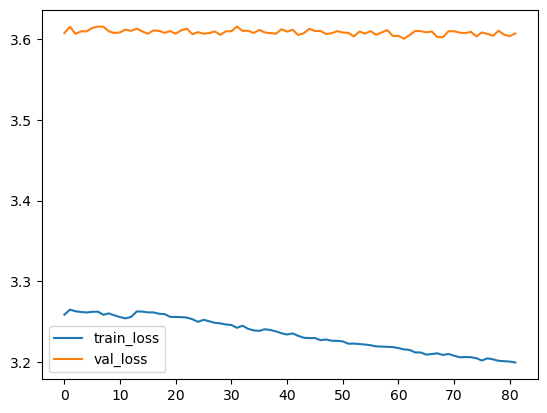

In [105]:
_ = log.plot()

In [106]:
_ = model.compute_baseline_hazards()

In [107]:
surv = model.predict_surv_df(X_test)

In [108]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [109]:
# num_nodes = [1024, 1024]
# earlystopping = patience=20
# batch_size = 128
# dropout = 0.1
# lr = 0.0001
# epoch = 256
ev.concordance_td()

0.8030869142332169

In [9]:
import dill

In [110]:
with open('C:/Users/user/desktop/kopis/ds_gC.pkl', 'wb') as f:
    dill.dump(model, f)

In [10]:
with open('C:/Users/user/desktop/kopis/ds_gC.pkl', 'rb') as f:
    modelC = dill.load(f)

In [30]:
_ = modelC.compute_baseline_hazards()
surv = modelC.predict_surv_df(X_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

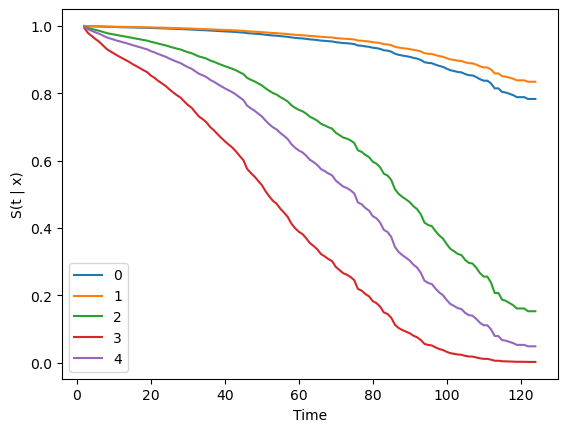

In [12]:
surv.iloc[:, :5].plot()
#surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [13]:
test_dummies['y'].describe()

count    119141.000000
mean         19.059677
std          17.584453
min           2.000000
25%           5.000000
50%          14.000000
75%          29.000000
max         124.000000
Name: y, dtype: float64

In [14]:
y_test = np.array(list(zip(test_dummies['delta'], test_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

In [15]:
y_train = np.array(list(zip(train_dummies['delta'], train_dummies['y'])), dtype=[('death', 'bool'),('futime', 'int')])

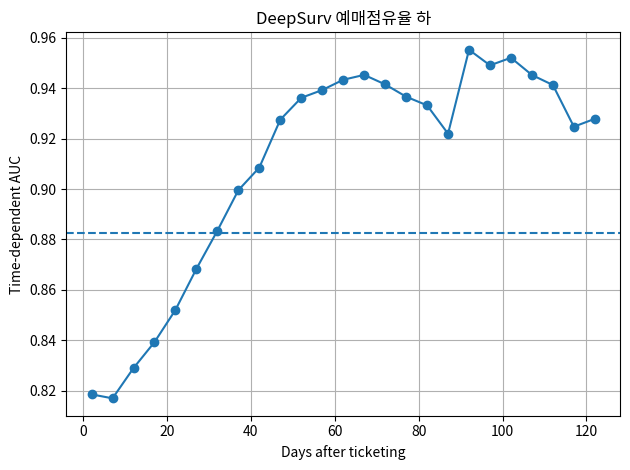

In [24]:
time_interval = np.arange(2, 124, 5)

cph_risk_scores = modelC.predict(X_test).ravel()
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, time_interval)

fig, ax = plt.subplots()

ax.plot(time_interval, cph_auc, marker='o')
ax.axhline(cph_mean_auc, ls='--')
ax.set_xlabel('Days after ticketing')
ax.set_ylabel('Time-dependent AUC')
plt.title('DeepSurv 예매점유율 하')

plt.grid(True)
plt.tight_layout()

In [25]:
time_interval

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102, 107, 112, 117, 122])

In [26]:
cph_auc

array([0.81860453, 0.81703392, 0.82902782, 0.83931361, 0.85208259,
       0.86836872, 0.88348076, 0.89953105, 0.90851713, 0.92748854,
       0.93615834, 0.93924014, 0.94331016, 0.94524448, 0.94147516,
       0.93660585, 0.93317016, 0.921941  , 0.9552038 , 0.94903179,
       0.95203392, 0.94520563, 0.94122717, 0.92470675, 0.92783823])

In [31]:
ev.integrated_brier_score(train_dummies.loc[train_dummies['delta']==1, 'y'].drop_duplicates().sort_values().values)

0.10371280665176659

In [32]:
ev.brier_score(time_interval)

2      0.035283
7      0.100997
12     0.118639
17     0.127051
22     0.132843
27     0.133669
32     0.131203
37     0.125079
42     0.121044
47     0.109106
52     0.102239
57     0.099486
62     0.095469
67     0.092587
72     0.094544
77     0.098055
82     0.099823
87     0.107374
92     0.086742
97     0.090101
102    0.084445
107    0.087220
112    0.086013
117    0.092125
122    0.090791
Name: brier_score, dtype: float64